## 获取数据

In [43]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open      High       Low     Close    Volume
Date                                                        
2020-01-02   67.4205   68.4340   67.3245   68.4340  27285300
2020-01-03   67.4000   68.6875   67.3660   68.0760  23412580
2020-01-06   67.5815   69.9160   67.5500   69.8905  46786860
2020-01-07   70.0230   70.1750   69.5780   69.7555  34529120
2020-01-08   69.7410   70.5925   69.6315   70.2520  35325480
...              ...       ...       ...       ...       ...
2023-12-22  140.7700  141.9900  140.7100  141.4900  26532199
2023-12-26  141.5900  142.6800  141.1900  141.5200  16780333
2023-12-27  141.5900  142.0800  139.8860  140.3700  19628618
2023-12-28  140.7800  141.1400  139.7500  140.2300  16045712
2023-12-29  139.6300  140.3600  138.7800  139.6900  18733017

[1006 rows x 5 columns]


In [44]:
df.iloc[:,:-1]

,Open,High,Low,Close
Date,,,,
2020-01-02,67.4205,68.4340,67.3245,68.4340
2020-01-03,67.4000,68.6875,67.3660,68.0760
2020-01-06,67.5815,69.9160,67.5500,69.8905
2020-01-07,70.0230,70.1750,69.5780,69.7555
2020-01-08,69.7410,70.5925,69.6315,70.2520
...,...,...,...,...
2023-12-22,140.7700,141.9900,140.7100,141.4900
2023-12-26,141.5900,142.6800,141.1900,141.5200
2023-12-27,141.5900,142.0800,139.8860,140.3700


## 输入输出

In [68]:
# def stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=10):
mem_his_days=5
per_days=10
df.dropna(inplace=True)
df.sort_index(inplace=True)

df['label'] = df['Close'].shift(-per_days)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-1])
# print(sca_X)

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))



X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

# import numpy as np
# X = np.array(X)
# y = np.array(y)

    # return X,y,X_lately

In [71]:
sca_X

array([[-1.42645928, -1.43023068, -1.39481315, -1.39277352, -0.52089095],
       [-1.42726705, -1.42028057, -1.39316325, -1.4069242 , -0.76995069],
       [-1.42011531, -1.37206077, -1.38584804, -1.33520237,  0.73328013],
       ...,
       [ 0.08681272,  0.07135385,  0.05691954,  0.0071165 ,  0.72538553],
       [ 0.05115254,  0.05800853,  0.00881404,  0.00158271,  1.15520741],
       [ 0.0326329 ,  0.13729546,  0.04499256,  0.15494767,  0.94565714]])

In [72]:
y

array([ 74.2345,  73.3085,  71.5865,  72.525 ,  72.835 ,  72.7125,
        71.639 ,  74.13  ,  72.2705,  72.3025,  73.7985,  73.9555,
        75.433 ,  75.503 ,  75.9315,  75.6695,  75.9365,  75.972 ,
        76.2435,  75.8495,  74.173 ,  70.993 ,  69.316 ,  69.5235,
        65.7475,  66.9625,  69.316 ,  66.886 ,  69.08  ,  65.738 ,
        64.787 ,  60.7895,  63.7585,  60.545 ,  55.5775,  60.7135,
        53.65  ,  55.903 ,  54.5595,  55.5835,  53.4105,  52.7065,
        56.5005,  55.081 ,  58.146 ,  55.513 ,  57.3155,  58.0975,
        55.105 ,  55.8515,  54.635 ,  59.1595,  59.128 ,  60.35  ,
        60.3285,  60.5205,  63.2615,  62.865 ,  62.8715,  63.95  ,
        63.0575,  60.608 ,  62.9205,  63.5585,  63.83  ,  63.543 ,
        61.6295,  67.109 ,  67.335 ,  65.866 ,  66.145 ,  67.451 ,
        67.2715,  68.464 ,  69.217 ,  70.1795,  68.759 ,  67.4165,
        67.843 ,  68.653 ,  69.259 ,  68.72  ,  70.458 ,  70.3375,
        70.662 ,  71.0685,  71.014 ,  70.912 ,  71.676 ,  71.7

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-1])
# sca_X = df.iloc[:,:-1]
print(sca_X)

[[-1.50852918 -1.51242597 -1.47633483 -1.47434421 -0.52178383]
 [-1.50935309 -1.50228268 -1.47465265 -1.48877279 -0.77520922]
 [-1.50205852 -1.45312675 -1.46719433 -1.41564245  0.75437105]
 ...
 [ 0.97763223  1.01143189  0.97945937  0.93079561 -0.59626225]
 [ 0.97280938  1.01543319  1.02445251  1.0686329  -0.81881031]
 [ 1.03148744  1.01143189  1.04573304  1.06339347 -0.76718638]]


In [52]:
X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=50)

[[-1.50852918 -1.51242597 -1.47633483 -1.47434421 -0.52178383]
 [-1.50935309 -1.50228268 -1.47465265 -1.48877279 -0.77520922]
 [-1.50205852 -1.45312675 -1.46719433 -1.41564245  0.75437105]
 ...
 [ 0.97763223  1.01143189  0.97945937  0.93079561 -0.59626225]
 [ 0.97280938  1.01543319  1.02445251  1.0686329  -0.81881031]
 [ 1.03148744  1.01143189  1.04573304  1.06339347 -0.76718638]]


In [47]:
print(len(X))
print(len(y))
print(len(X_lately))

0
952
1


In [48]:
X[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

## 参数寻优

In [14]:
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dens_layers = [1,2,3]
# units = [8,16,32]
mem_days = [5]
lstm_layers = [1]
dens_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dens_layers in dens_layers:
            for the_units in units:
                # save model
                filepath = '{val_mape:.2f}_{epoch:02d}'+f'_mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dens_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)
                # print(filepath)
                X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=the_mem_days,per_days=10)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
            
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dens_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                # model.summary()
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(X_train,y_train,batch_size=32,epochs=50,
                          validation_data=(X_test,y_test),
                          callbacks=[checkpoint])

                

Epoch 1/50
28/28 [==============================] - 3s 22ms/step - loss: 11651.4611 - mape: 99.8918 - val_loss: 17493.7891 - val_mape: 99.4470
INFO:tensorflow:Assets written to: 99.45_01_mem_5_lstm_1_dense_1_unit_32\assets
Epoch 2/50
28/28 [==============================] - 0s 9ms/step - loss: 10347.3222 - mape: 92.7067 - val_loss: 2912.8574 - val_mape: 33.6115
INFO:tensorflow:Assets written to: 33.61_02_mem_5_lstm_1_dense_1_unit_32\assets
Epoch 3/50
28/28 [==============================] - 0s 9ms/step - loss: 4716.4767 - mape: 56.1884 - val_loss: 1611.8400 - val_mape: 26.5446
INFO:tensorflow:Assets written to: 26.54_03_mem_5_lstm_1_dense_1_unit_32\assets
Epoch 4/50
28/28 [==============================] - 0s 9ms/step - loss: 1245.8792 - mape: 28.1968 - val_loss: 160.4651 - val_mape: 7.7684
INFO:tensorflow:Assets written to: 7.77_04_mem_5_lstm_1_dense_1_unit_32\assets
Epoch 5/50
28/28 [==============================] - 0s 9ms/step - loss: 332.9750 - mape: 13.9934 - val_loss: 119.9756 -

## 构建网络

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
model = Sequential()
model.add(LSTM(32,input_shape=X.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 10)             640       
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [13]:
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

Epoch 1/50
28/28 [==============================] - 3s 33ms/step - loss: 12169.3063 - mape: 99.9658 - val_loss: 12401.5850 - val_mape: 99.8489
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 12267.2197 - mape: 99.7132 - val_loss: 12218.6221 - val_mape: 98.6837
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 11522.3411 - mape: 94.8876 - val_loss: 8837.9561 - val_mape: 82.1269
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 7237.8296 - mape: 72.8243 - val_loss: 4940.4585 - val_mape: 56.0306
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 5091.3301 - mape: 57.8845 - val_loss: 3138.0659 - val_mape: 44.4652
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 3634.0319 - mape: 49.1188 - val_loss: 1861.2069 - val_mape: 32.8858
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 2314.9122 - mape: 37.2475 - val_loss: 760.9581 - val_mape: 20.4911
Epoch 8/50
28/2

## 读取推理

In [19]:
from tensorflow.keras.models import load_model
best_model = load_model('E:\\Document\\Timing-signal-analysis\\3.90_18_mem_5_lstm_1_dense_1_unit_32')


In [20]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(pre)

4/4 [==============================] - 1s 3ms/step - loss: 37.3175 - mape: 3.8956
[[123.19305 ]
 [121.91545 ]
 [123.00309 ]
 [123.482086]
 [125.76206 ]
 [126.284256]
 [126.82273 ]
 [125.10234 ]
 [124.58599 ]
 [125.03627 ]
 [129.00792 ]
 [125.389015]
 [129.35094 ]
 [133.85481 ]
 [132.74112 ]
 [131.09557 ]
 [131.66861 ]
 [131.28328 ]
 [130.87273 ]
 [130.99112 ]
 [131.26332 ]
 [131.16006 ]
 [131.37364 ]
 [132.29118 ]
 [132.42537 ]
 [131.08458 ]
 [131.18092 ]
 [131.69702 ]
 [129.79741 ]
 [129.85948 ]
 [129.49187 ]
 [129.96861 ]
 [130.83391 ]
 [131.54837 ]
 [132.98906 ]
 [131.91083 ]
 [133.22847 ]
 [133.73344 ]
 [134.21786 ]
 [135.76518 ]
 [136.99768 ]
 [136.76053 ]
 [136.91888 ]
 [135.06467 ]
 [135.47653 ]
 [137.24959 ]
 [137.3057  ]
 [135.71465 ]
 [136.28221 ]
 [136.39548 ]
 [136.44899 ]
 [136.04164 ]
 [134.29988 ]
 [131.05496 ]
 [131.67894 ]
 [131.52026 ]
 [131.20042 ]
 [131.4308  ]
 [132.21176 ]
 [133.32858 ]
 [133.32056 ]
 [133.95766 ]
 [134.08598 ]
 [135.47826 ]
 [135.5944  ]
 [137.40

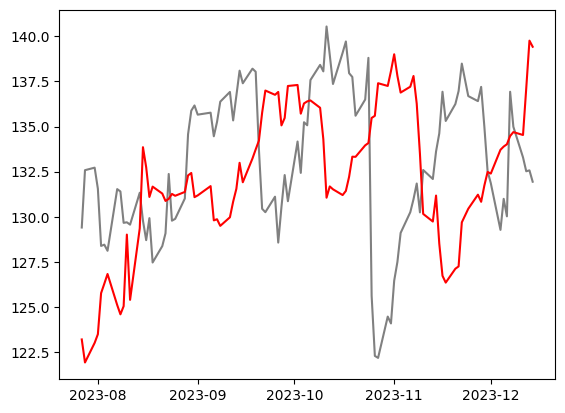

In [22]:
import matplotlib.pyplot as plt
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,pre,color='red',label='predict')
plt.show()

In [24]:
y_test

array([129.4  , 132.58 , 132.72 , 131.55 , 128.38 , 128.45 , 128.11 ,
       131.53 , 131.4  , 129.66 , 129.69 , 129.56 , 131.33 , 129.78 ,
       128.7  , 129.92 , 127.46 , 128.37 , 129.08 , 132.37 , 129.78 ,
       129.88 , 131.01 , 134.57 , 135.88 , 136.17 , 135.66 , 135.77 ,
       134.46 , 135.26 , 136.38 , 136.92 , 135.34 , 136.71 , 138.1  ,
       137.4  , 138.21 , 138.04 , 133.74 , 130.44 , 130.25 , 131.11 ,
       128.565, 130.54 , 132.31 , 130.86 , 134.17 , 132.43 , 135.24 ,
       135.07 , 137.58 , 138.42 , 138.06 , 140.55 , 138.97 , 137.36 ,
       139.095, 139.72 , 137.96 , 137.75 , 135.6  , 136.5  , 138.81 ,
       125.61 , 122.28 , 122.17 , 124.46 , 124.08 , 126.45 , 127.49 ,
       129.1  , 130.25 , 130.97 , 131.84 , 130.24 , 132.59 , 132.09 ,
       133.62 , 134.62 , 136.93 , 135.31 , 136.25 , 136.97 , 138.49 ,
       136.69 , 136.41 , 137.2  , 134.99 , 132.53 , 131.86 , 129.27 ,
       130.99 , 130.02 , 136.93 , 134.99 , 133.29 , 132.52 , 132.57 ,
       131.94 ])